In [10]:
import xarray as xr
import matplotlib.pyplot as plt 
%matplotlib inline

In [11]:
# Load sample data:
sample_data = xr.open_dataset('RAW/era5_201001_sfc.nc')

# Find sea level pressure 
sample_data.msl

<xarray.DataArray 'msl' (time: 744, latitude: 25, longitude: 35)>
[651000 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 ...
  * latitude   (latitude) float32 58.2 57.9 57.6 57.3 57.0 56.7 56.4 56.1 ...
  * time       (time) datetime64[ns] 2010-01-01 2010-01-01T01:00:00 ...
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_sea_level

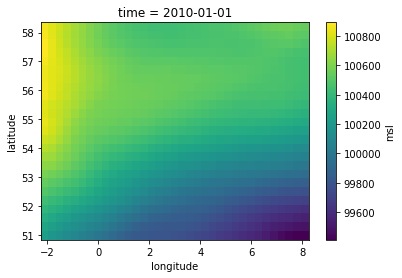

In [12]:
# Let's give msl a name for easy reference
msl = sample_data.msl

# Make a plot of msl for the first timestep
msl.isel(time=0).plot()

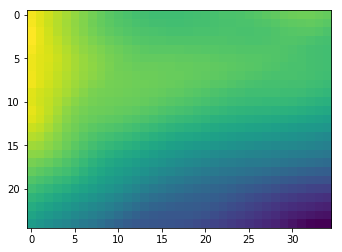

In [71]:
# Note how xarray automatically identified the lontitude and latitude labels. 
# Plotting the raw data would give something like:
fig, ax = plt.subplots()
ax.imshow(msl.isel(time=0).values)

Now, for PCA dimensionality reduction, each pixel corresponds to a dimension, varying in time. 
That means we need to reshape the array to a shape (time, pixel).

In [38]:
print msl.shape
print msl.dims

(744, 25, 35)
(u'time', u'latitude', u'longitude')


In [82]:
ntime, nlat, nlon = msl.shape
msl_reshaped = msl.values.reshape(ntime,-1) # -1 means infer the remaining dimension
msl_reshaped.shape

(744, 875)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[[-0.03144587 -0.03193463 -0.0324161  ... -0.02877749 -0.02881295
  -0.02892082]
 [-0.00447333 -0.00696748 -0.00945054 ...  0.02647286  0.0244932
   0.02194588]
 [-0.08093659 -0.07797405 -0.07502148 ...  0.06051119  0.06262088
   0.06484599]]

(3, 875)

[0.91528948 0.04652603 0.03145199]


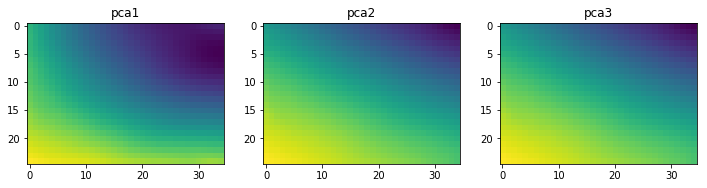

In [91]:
# We'll use the PCA analysis toolkit from scikit-learn:
from sklearn.decomposition import PCA

# This takes some getting used to. PCA is an object that can perform principal component analysis. 
# We can further specify what kind of PCA we want, for example a PCA with 2 components:
pca3 = PCA(n_components=3) 

# Now, we can "train" the pca3 object to our specific dataset:
pca3_msl = pca.fit(msl_reshaped)

# pca3_msl can be interpreted as containing the 'basis functions' for each pixel.
# We can read some of the transformation properties:
print pca3_msl
print ""
print pca3_msl.components_
print ""
print pca3_msl.components_.shape
print ""
print pca3_msl.explained_variance_ratio_

# Let's see what the components look like:
# If we want to plot the basis functions, we need to reshape back to the original shape
fig, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].imshow(pca3_msl.components_[0].reshape(nlat, nlon))
axs[0].set_title('pca1')
axs[1].imshow(pca3_msl.components_[1].reshape(nlat, nlon))
axs[1].set_title('pca2')
axs[2].imshow(pca3_msl.components_[1].reshape(nlat, nlon))
axs[2].set_title('pca3')

In [80]:
# Let's actually perform the transformation. 
coefficients = pca3_msl.transform(msl_reshaped)
print coefficients.shape
print coefficients

(744, 3)
[[37691.96282751 -4868.37473471 -6870.22602081]
 [38611.08733836 -4462.20473297 -6544.95484947]
 [39232.83543211 -4033.03309009 -6349.32283935]
 ...
 [44292.40285782  9052.66850737  1641.11196041]
 [43620.29761276  8612.14630317  1409.84451294]
 [42889.75393745  8233.99909068  1008.98514358]]


(744, 875)
[[101006.63982712 100983.53421015 100960.50292925 ...  99936.86350243
   99943.13451585  99947.04306136]
 [100949.59388255 100925.98962102 100902.46765376 ...  99940.84843144
   99946.96899443  99950.46751301]
 [100912.28885637 100887.88986259 100863.58050413 ...  99946.15540787
   99951.81703069  99954.59054627]
 ...
 [100047.93108489 100012.09352487  99976.44797804 ... 100630.48046847
  100626.91470609 100613.58853228]
 [100089.75462127 100054.65914412 100019.74820192 ... 100624.16582004
  100621.00807396 100608.36195597]
 [100146.86297321 100111.88014413 100077.07633098 ... 100610.92191866
  100607.69299257 100595.1969848 ]]


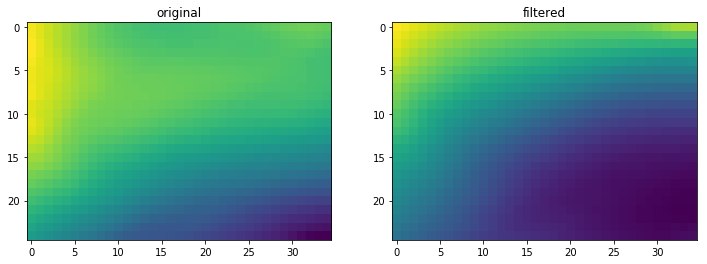

In [93]:
# Now, if we do the inverse transform, we get the original image back.
# However, only the first n principal components are retained. The rest of the data is filtered out.
inversed = pca3_msl.inverse_transform(coefficients)
print inversed.shape
print inversed

# If we want to plot the result, we need to reshape back to the original shape
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(msl.isel(time=0).values)
axs[0].set_title('original')
axs[1].imshow(inversed[0].reshape(nlat, nlon))
axs[1].set_title('filtered')

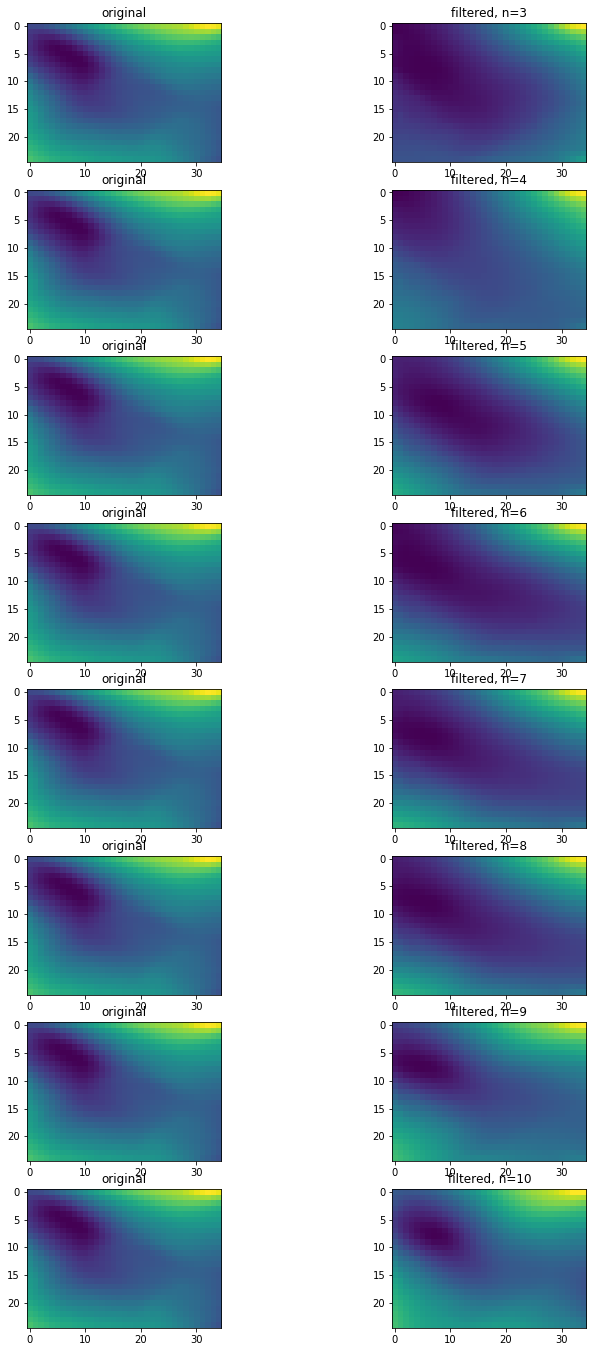

In [104]:
# Now, we can automated this a little bit:
def my_pca_routine(data, n):
    """ Returns filtered field based on n principal components """
    from sklearn.decomposition import PCA
    
    # assuming the data is always in the same format:
    ntime, nlat, nlon = data.shape
    reshaped = data.reshape(ntime, -1)
    
    pca = PCA(n_components=n).fit(reshaped)
    
    
    components = pca.transform(reshaped)
    projected = pca.inverse_transform(components)
    return projected.reshape(ntime, nlat, nlon)


t = 25 # just a random time index to check the result (some msl fields are simpler than others)
fig, axs = plt.subplots(8, 2, figsize=(12,24))
for i,n in enumerate(range(3,11)):
    filtered = my_pca_routine(msl.values, n)
    
    axs[i,0].imshow(msl.isel(time=t).values)
    axs[i,0].set_title('original')
    axs[i,1].imshow(filtered[t])
    axs[i,1].set_title('filtered, n=%s'%n)    
    

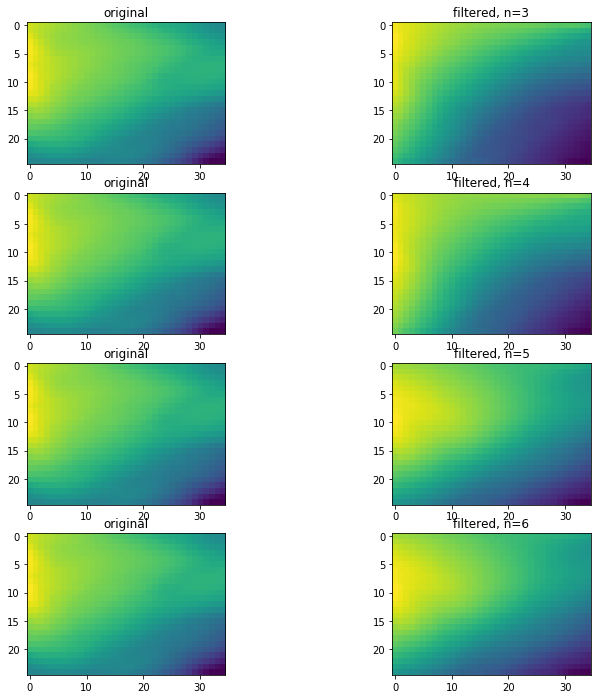

In [109]:
# This might be faster but uses random numbers. So might not always produce the same results.
def my_pca_routine(data, n):
    """ Returns filtered field based on n principal components """
    from sklearn.decomposition import PCA
    
    # assuming the data is always in the same format:
    ntime, nlat, nlon = data.shape
    reshaped = data.reshape(ntime, -1)
    
    # Using a randomized filter
    pca = PCA(n_components=n, svd_solver='randomized').fit(reshaped)
        
    components = pca.transform(reshaped)
    projected = pca.inverse_transform(components)
    return projected.reshape(ntime, nlat, nlon)


t = 55 # just a random time index to check the result (some msl fields are simpler than others)
fig, axs = plt.subplots(4, 2, figsize=(12,12))
for i,n in enumerate(range(3,7)):
    filtered = my_pca_routine(msl.values, n)
    
    axs[i,0].imshow(msl.isel(time=t).values)
    axs[i,0].set_title('original')
    axs[i,1].imshow(filtered[t])
    axs[i,1].set_title('filtered, n=%s'%n)

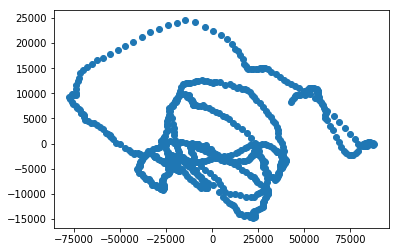

In [122]:
# Now, we can try to cluster the principal components and pick out the dominant circulation patterns
ntime, nlat, nlon = msl.shape
reshaped = msl.values.reshape(ntime, -1)

# First, let's visualize the first two components
pca = PCA(n_components=2).fit(reshaped)
components = pca.transform(reshaped)
fig,ax = plt.subplots()
ax.scatter(components[:,0], components[:,1])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

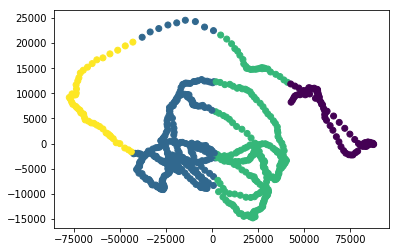

In [159]:
# Now, let's use scipy's kmeans algorithm to cluster them:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=0).fit_predict(components)

# These are the cluster numbers for each time step:
print clusters

# Let's use these labels to color the data
fig,ax = plt.subplots()
ax.scatter(components[:,0], components[:,1], c=clusters)

In [160]:
# Now, let's compute cluster-averaged msl maps
# We will replace the 'time' coordinate with the cluster labels
msl['time']=clusters

# Now, we can use this coordinate as an index to groupby
msl.groupby('time').mean(dim='time')

<xarray.DataArray 'msl' (time: 4, latitude: 25, longitude: 35)>
array([[[ 99686.174347,  99637.571289, ...,  99116.303052,  99119.520672],
        [ 99713.884916,  99663.196387, ...,  99044.706922,  99049.435752],
        ...,
        [100235.156931, 100212.007701, ...,  99588.07158 ,  99577.776456],
        [100257.153864, 100232.472013, ...,  99643.540572,  99628.051921]],

       [[102252.786177, 102268.301062, ..., 102896.309235, 102902.573044],
        [102242.191357, 102256.832899, ..., 102819.835741, 102826.103226],
        ...,
        [102031.862081, 102034.256619, ..., 102116.695983, 102127.431766],
        [102021.741863, 102022.002002, ..., 102120.881831, 102133.008609]],

       [[100844.649235, 100844.273531, ..., 101342.355177, 101350.631995],
        [100835.108038, 100833.249668, ..., 101243.52325 , 101249.277186],
        ...,
        [100842.021407, 100834.806635, ..., 100914.543574, 100928.408094],
        [100837.576769, 100827.493634, ..., 100952.105138, 100969.99

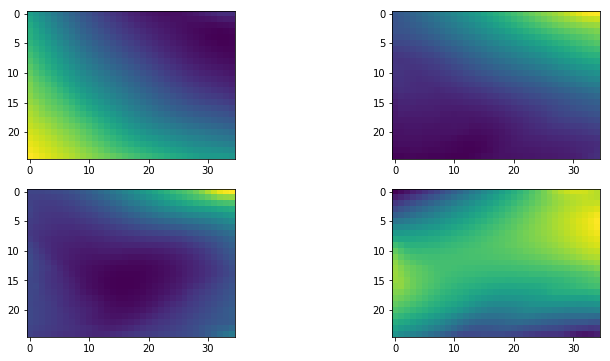

In [163]:
msl['time']=clusters
meanmaps = msl.groupby('time').mean(dim='time')
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(meanmaps.isel(time=i))